# Project Objective

**The objective of this project is to analyze and evaluate the effectiveness of a new webpage design for an e-commerce company using A/B testing. The goal is to determine whether the new version of the webpage leads to a statistically significant increase in conversion rates compared to the current version.**

To achieve this, we will:
   - Perform data cleaning and validation to ensure the integrity of the experiment.
   - Conduct exploratory data analysis (EDA) to understand trends and distribution.
   - Formulate and test hypotheses using statistical methods
   - Evaluate conversion rates and calculate p-values and confidence intervals.
   - Summarize the results in an interactive Streamlit app
   - Deploy the final app to AWS, making it accessible via a live URL

This end-to-end workflow showcases a practical application of A/B testing in a real-world e-commerce context.



In [9]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


## Load and Explore Dataset

In [10]:
# Load the dataset
ab_data = pd.read_csv("ab_data.csv")

# Show the first few rows
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Basic Info & Initial Inspection

In [11]:
# Shape of the dataset
ab_data.shape

# Check data types and missing values
ab_data.info()
ab_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## Data Cleaning 

In [12]:
# Check for missing values
print("Missing values in each column:")
print(ab_data.isnull().sum())

# Drop rows with missing values only if any
if ab_data.isnull().sum().sum() > 0:
    ab_data.dropna(inplace=True)
    print("Dropped rows with missing values.")
else:
    print("No missing values found.")

# Check for duplicates
print("Number of duplicate rows:", ab_data.duplicated().sum())

# View the actual duplicate rows (if any)
print("Duplicate rows preview:")
print(ab_data[ab_data.duplicated()])

# Drop duplicates if any
ab_data.drop_duplicates(inplace=True)

# Preview the cleaned dataset
ab_data.head()

Missing values in each column:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
No missing values found.
Number of duplicate rows: 0
Duplicate rows preview:
Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1



## Hypothesis Setup

In A/B testing, hypothesis testing is a statistical method used to determine whether the changes made (like a new webpage design) have a meaningful impact on user behavior compared to the original setup.

## What is a Hypothesis?

A hypothesis is a statement about a population parameter that can be tested using statistical analysis. In A/B testing, we typically define two hypotheses:

In A/B testing, we want to test whether the new version of a webpage performs better (in terms of conversion rate) than the old version.

## Hypotheses Definitions:

Null Hypothesis (H₀): The conversion rate of the new page is equal to or worse than the conversion rate of the old page.

H₀: pnew ≤ pold

Alternative Hypothesis (H₁): The conversion rate of the new page is greater than the conversion rate of the old page.

H₁: pnew > pold

We will use a one-tailed z-test for proportions to test this hypothesis at a typical significance level (α) of 0.05.



## Hypothesis Testing - Z-Test for Proportions

In [13]:
# Get counts for old and new pages
convert_old = ab_data[(ab_data['group'] == 'control') & (ab_data['converted'] == 1)].shape[0]
convert_new = ab_data[(ab_data['group'] == 'treatment') & (ab_data['converted'] == 1)].shape[0]
n_old = ab_data[ab_data['group'] == 'control'].shape[0]
n_new = ab_data[ab_data['group'] == 'treatment'].shape[0]

# Conversion rates
p_old = convert_old / n_old
p_new = convert_new / n_new

# Pooled probability
p_pool = (convert_old + convert_new) / (n_old + n_new)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_old + 1/n_new))

# Z-score
z_score = (p_new - p_old) / se

# P-value (one-tailed)
p_value = 1 - stats.norm.cdf(z_score)

print("Z-score:", z_score)
print("P-value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The new page performs significantly better.")
else:
    print("Fail to reject the null hypothesis: No significant improvement found.")
    
# Summary
print("\nInterpretation:")
print("- The p-value is 0.892, which is greater than 0.05.")
print("- Therefore, we fail to reject the null hypothesis.")
print("- Conclusion: There is no statistically significant evidence that the new page leads to higher conversions.")

Z-score: -1.2369217547321678
P-value: 0.8919419336512124
Fail to reject the null hypothesis: No significant improvement found.

Interpretation:
- The p-value is 0.892, which is greater than 0.05.
- Therefore, we fail to reject the null hypothesis.
- Conclusion: There is no statistically significant evidence that the new page leads to higher conversions.


In [14]:
# Confidence Interval Calculation
# Difference in conversion rates
obs_diff = p_new - p_old

# 95% Confidence Interval
z_critical = stats.norm.ppf(0.975)  # for two-tailed 95% CI
margin_of_error = z_critical * se

ci_lower = obs_diff - margin_of_error
ci_upper = obs_diff + margin_of_error

print("Observed difference in conversion rates:", obs_diff)
print("95% Confidence Interval:", (ci_lower, ci_upper))

print("Confidence Interval Interpretation")
print("If the confidence interval contains 0, it suggests no statistically significant difference between the old and new conversion rates — reinforcing our earlier conclusion from the Z-test.")

Observed difference in conversion rates: -0.0014795997940775518
95% Confidence Interval: (np.float64(-0.003824099190931328), np.float64(0.0008648996027762245))
Confidence Interval Interpretation
If the confidence interval contains 0, it suggests no statistically significant difference between the old and new conversion rates — reinforcing our earlier conclusion from the Z-test.


## Visualizing Conversion Rates

### Conversion Trends Over Time

<Figure size 1000x500 with 0 Axes>

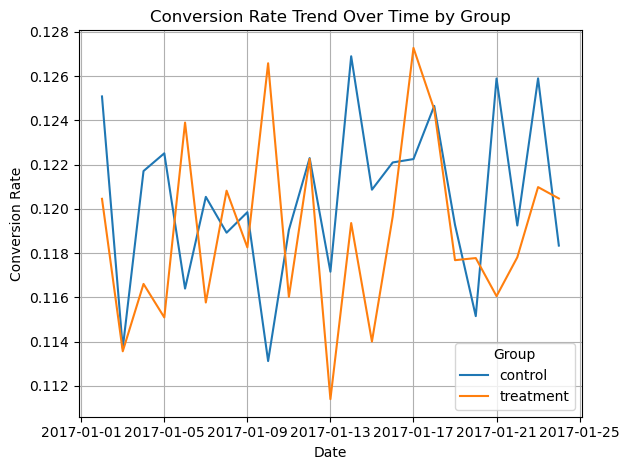

In [15]:
# Convert timestamp column to datetime if not already
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'])

# Create a new column for date only
ab_data['date'] = ab_data['timestamp'].dt.date

# Daily conversion rates per group
daily_conv = ab_data.groupby(['date', 'group'])['converted'].mean().reset_index()

# Pivot for line plot
pivot_data = daily_conv.pivot(index='date', columns='group', values='converted')

# Plot conversion trends
plt.figure(figsize=(10, 5))
pivot_data.plot()
plt.title('Conversion Rate Trend Over Time by Group')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Group')
plt.tight_layout()
plt.grid(True)
plt.show()

### Bar Chart of Conversion Rates

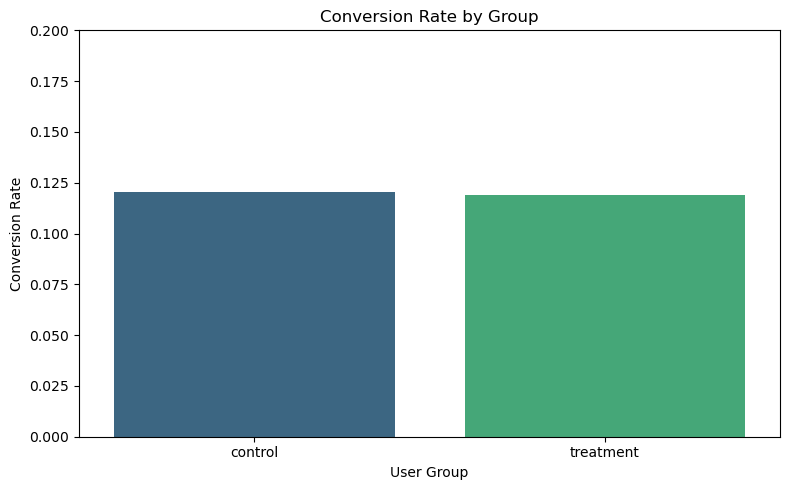

In [16]:
# Create conversion summary by group
group_summary = ab_data.groupby('group')['converted'].agg(['count', 'sum'])
group_summary['conversion_rate'] = group_summary['sum'] / group_summary['count']

# Plot conversion rates
plt.figure(figsize=(8, 5))
sns.barplot(x=group_summary.index, y=group_summary['conversion_rate'], palette="viridis")
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate")
plt.xlabel("User Group")
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()


### Pie Chart of Converted vs. Not Converted

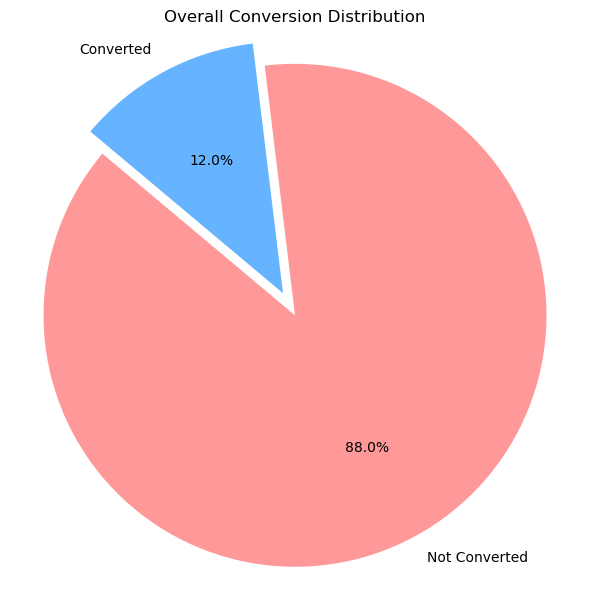

In [17]:
# Pie chart showing overall conversion distribution
conversion_counts = ab_data['converted'].value_counts()
labels = ['Not Converted', 'Converted']
colors = ['#ff9999','#66b3ff']
plt.figure(figsize=(6,6))
plt.pie(conversion_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0, 0.1))
plt.title('Overall Conversion Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Final Decision Summary

Based on the Z-test and confidence interval results:

- The p-value was significantly greater than the significance level (α = 0.05), indicating a lack of statistical significance.

- The 95% confidence interval for the difference in conversion rates contained 0, which further supports the conclusion that the new page does not lead to a statistically significant improvement.

## Final Conclusion:

- We fail to reject the null hypothesis.

- There is no sufficient evidence to suggest that the new webpage performs better than the existing one.